<a href="https://colab.research.google.com/github/rvtovar/sales_predictions/blob/main/sales_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(display='diagram')

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRuRgiZaLcdq_937t8Psne-9AWR5VwSQYnt6PgMdDPFaVdOeP4xxA9h7_2mAYEsh8DOYzoh0XAqeQa0/pub?gid=2071196080&single=true&output=csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
# how many rows and columns (8523 rows, 12 columns)
df.shape


(8523, 12)

In [4]:
#data types of each variable
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [5]:
#testing for duplicates
df.duplicated().sum()

# no duplicates found

0

In [6]:
#missing data 
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
#filling in missing item_weights with the average item weight, there are a significant amount missing so i felt like the best courese of action was to use the mean

#weight_mean = df["Item_Weight"].mean()
#df['Item_Weight'].fillna(weight_mean, inplace=True)

In [8]:
# As for outlet size we are going to use the most common one found, to substitute the data that is missing

#df['Outlet_Size'].value_counts()

In [9]:
#df['Outlet_Size'].fillna('Medium', inplace=True)

In [10]:
# looking at object columns to see if any spelling errors
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols
for col in str_cols:
  print(f"- Column = {col}")
  print(df[col].value_counts(dropna=False))
  print('\n\n')


- Column = Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64



- Column = Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



- Column = Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



- Column = Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045 

In [11]:
#fixing inconsistencies in Item Fat Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', "Regular")
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [12]:
# Now looking at summmary Statistics

df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.86,4.64,4.56,8.77,12.60,16.85,21.35
Item_Visibility,8523.0,0.07,0.05,0.00,0.03,0.05,0.09,0.33
Item_MRP,8523.0,140.99,62.28,31.29,93.83,143.01,185.64,266.89
Outlet_Establishment_Year,8523.0,1997.83,8.37,1985.00,1987.00,1999.00,2004.00,2009.00
Item_Outlet_Sales,8523.0,2181.29,1706.50,33.29,834.25,1794.33,3101.30,13086.96


### Data Visualizations

In [13]:
# Setting up Default Settings for plots
sns.set_context('talk')
plt.style.use(['bmh', 'seaborn'])
plt.rcParams['font.family'] = 'serif'

<AxesSubplot:>

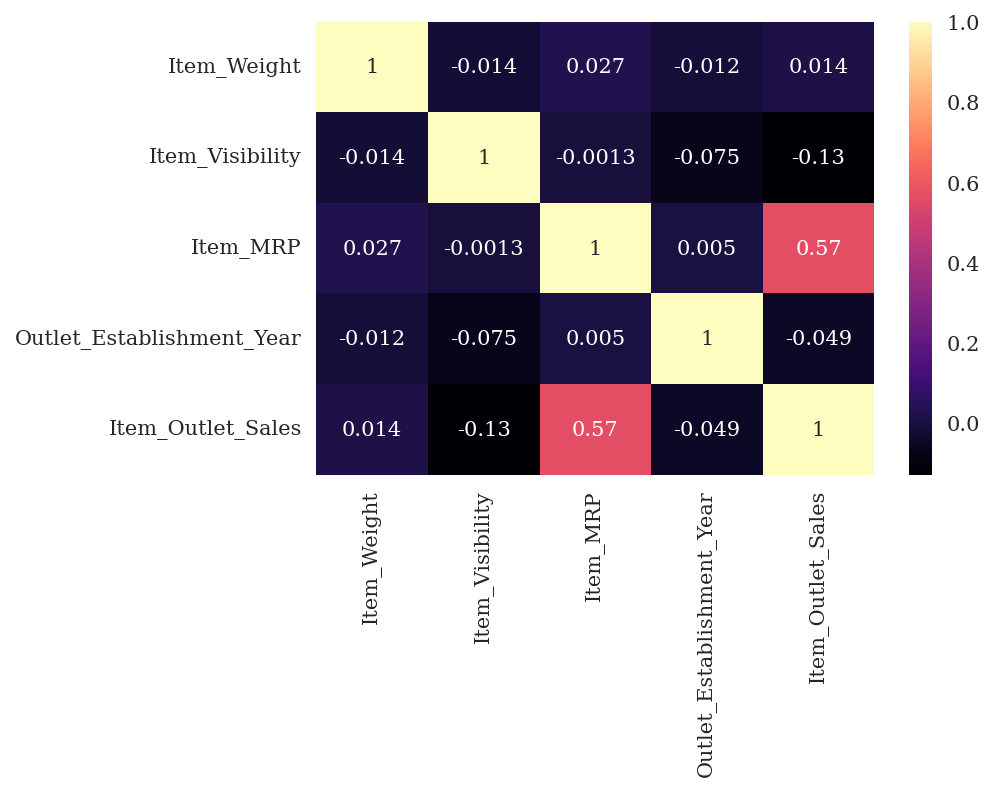

In [14]:
corr = df.corr()
plt.figure(dpi=150)
sns.heatmap(corr, annot=True, cmap='magma')

# The first thing i wanted to do is explore the correlations and which areas have the most correlation.
# We can see that there is a moderate correlation between Item_MRP and Item Outlet Sales. 
# Everwhere else has a no correlation . 

### In the following we are going to create histograms to view distrubtions of features

Text(0.5, 1.0, 'Item Weight Distribution')

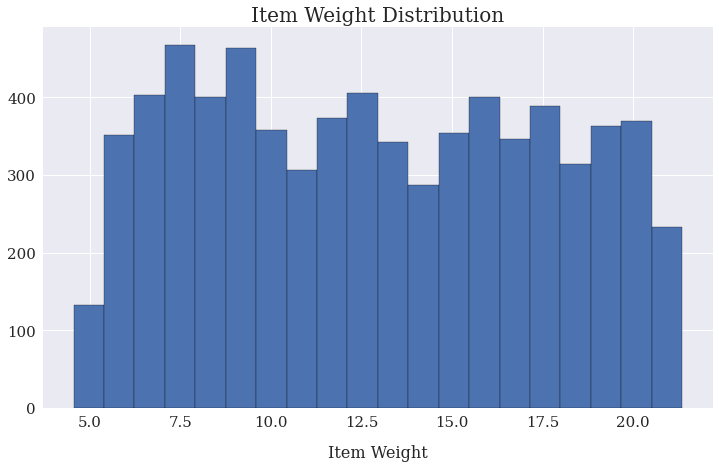

In [15]:
# The distrubtion of item weights, the large amount of 12.5 weights comes from replacing data that was missing
fig, ax = plt.subplots(figsize=(12,7))
df["Item_Weight"].hist(edgecolor='black', bins=20, ax=ax)
ax.set_xlabel("Item Weight", fontsize=16, labelpad=15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_title("Item Weight Distribution", fontsize='20')

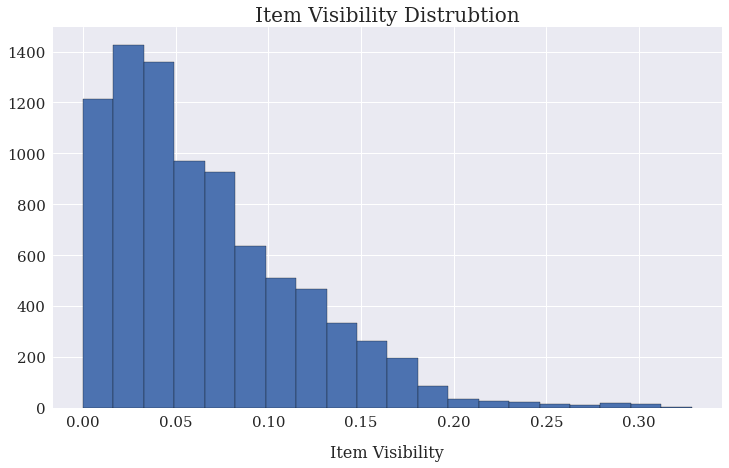

In [16]:
# item Visibility
fig, ax = plt.subplots(figsize=(12,7))
df["Item_Visibility"].hist(edgecolor='black', bins=20, ax=ax)
ax.set_xlabel("Item Visibility", fontsize=16, labelpad=15)
ax.set_title('Item Visibility Distrubtion', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

# This visualiztion shows us that many of these items have 0 to .15 Visibility

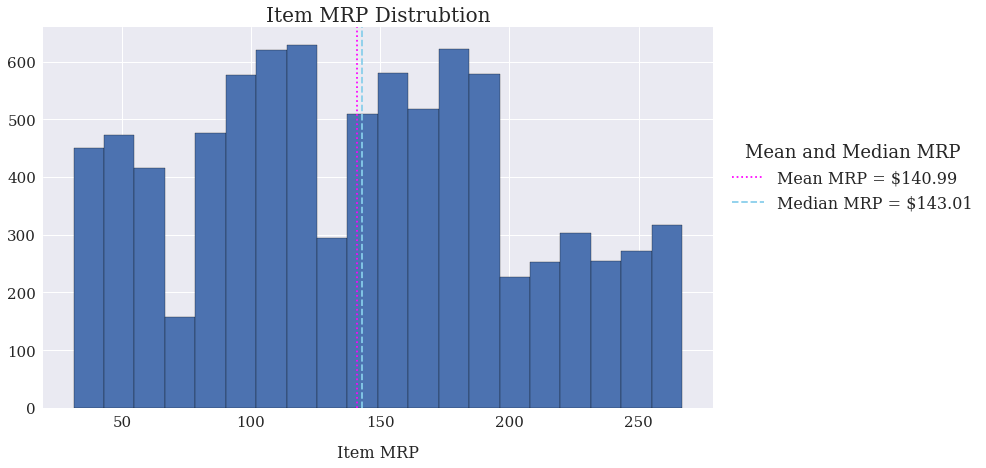

In [17]:
#item mrp
fig, ax = plt.subplots(figsize=(12,7))
df["Item_MRP"].hist(edgecolor='black', bins=20, ax=ax)
ax.set_xlabel("Item MRP", fontsize=16, labelpad=15)
ax.set_title('Item MRP Distrubtion', fontsize=20)

mean_mrp = df['Item_MRP'].mean()
med_mrp = df['Item_MRP'].median()

ax.axvline(mean_mrp,color='magenta', ls=':', label=f"Mean MRP = ${mean_mrp:,.2f}",);
ax.axvline(med_mrp,color='skyblue', ls='--', label=f"Median MRP = ${med_mrp:,.2f}");
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

ax.legend(loc=(1.02, .5), fontsize=16, title="Mean and Median MRP")
#Most of the MRPs rum between 50 to 200. With a few dips at what loosk to be points 75 and 125. 
#Once we get past 200 the MRP counts remain on the low side meaning many of items do not have 
# an mrp of above 200. 

### Box Plots to view Statiscal Summaries

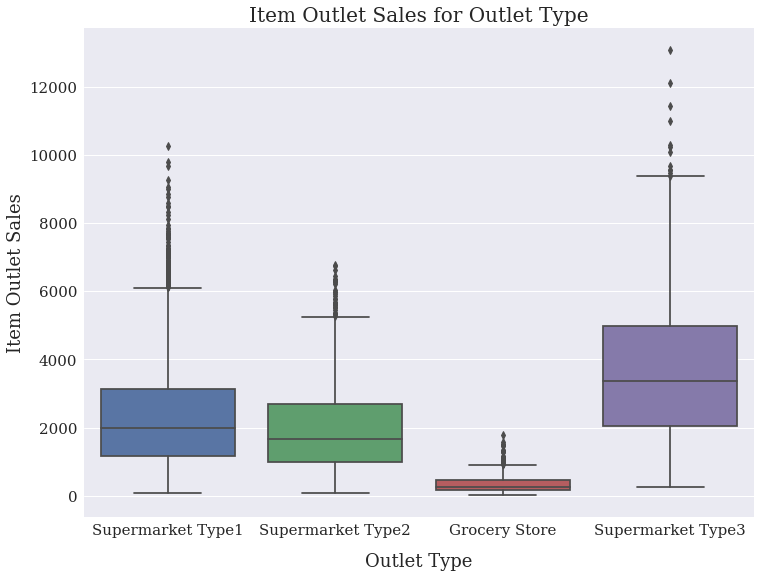

In [18]:
# Box plot of item outlet sales and Item Type
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=df, x="Outlet_Type", y="Item_Outlet_Sales", ax=ax)
ax.set_xlabel("Outlet Type", fontsize=18,labelpad=15)
ax.set_ylabel("Item Outlet Sales", fontsize=18)
ax.set_title('Item Outlet Sales for Outlet Type', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
 #We can look and tell there are many outliers for each of the outlet types
  #The mediam outlet sales is much lower than the supermarket types. Which is to be expected
  #since they most likely sell groceries. What i find interesting is type 2 has a lower median than type 1
  #Which means type 2 sees less sales than type 1 and type 3. 

Text(0.5, 1.0, 'Item outlet sales for item Type')

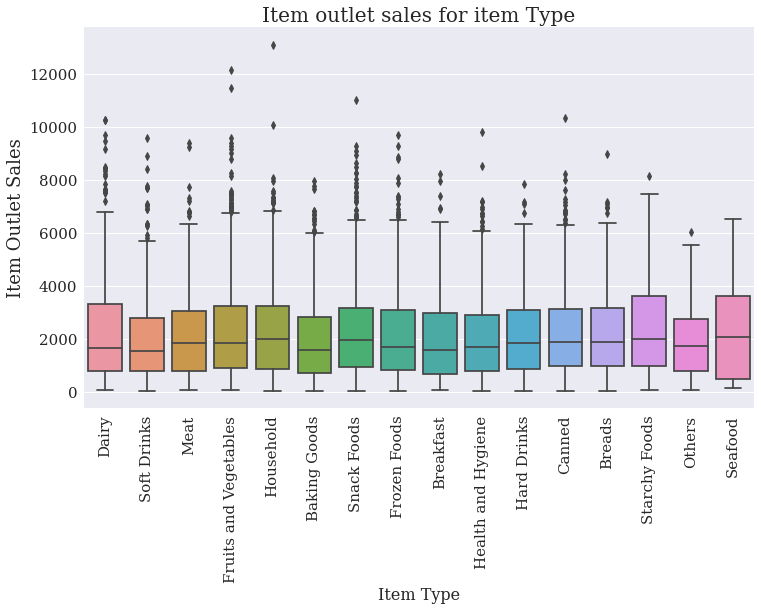

In [19]:
fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(data=df, x="Item_Type", y="Item_Outlet_Sales", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Item Type", fontsize=16)
ax.set_ylabel("Item Outlet Sales", fontsize=18)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

plt.title('Item outlet sales for item Type', fontsize=20)

  #Once again there are a significant amount of items that are outliers. We can see that the median sales
  #per item falls within the same range with some flucutation. 

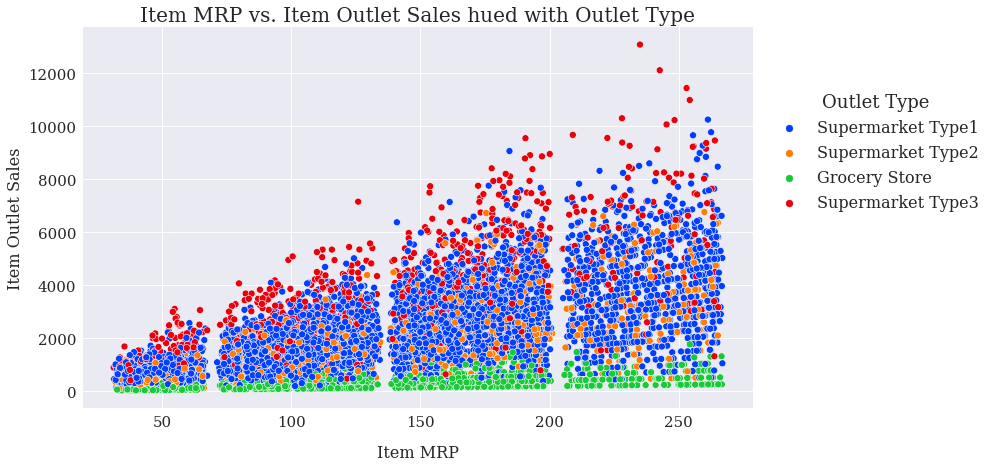

In [20]:
fig,ax = plt.subplots(nrows=1, ncols=1);
fig.set_size_inches(12, 7)
#ax.scatter(data=df, x="Item_MRP", y='Item_Outlet_Sales')
sns.scatterplot(data=df, x='Item_MRP', y="Item_Outlet_Sales", hue='Outlet_Type', palette='bright')
ax.set_xlabel('Item MRP', fontsize=16,labelpad=15)
ax.set_ylabel('Item Outlet Sales', fontsize=16)
ax.set_title('Item MRP vs. Item Outlet Sales hued with Outlet Type', fontsize=20);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc=(1.02, .5), fontsize=16, title="Outlet Type")
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

 #Looking at this plot we can see that the sales goes through a wider flucutation the larger the 
  #MRP is. with a low MRP item sales go between 0 and 2000, while if MRP goes to 250 we go from 0 to 12000. So
  #the higher the MRP the chance for higher sales on an item is. 
  #We can also look at the hue and tell that grocery stores sell the less , while supermarket type 3 sells the most
  # As for supermarket type2 and 3 they seem to be randomly distrubted in the middle sctions. with type 1 supermarkets getting
  # higher sells when they have higher item MRP. 

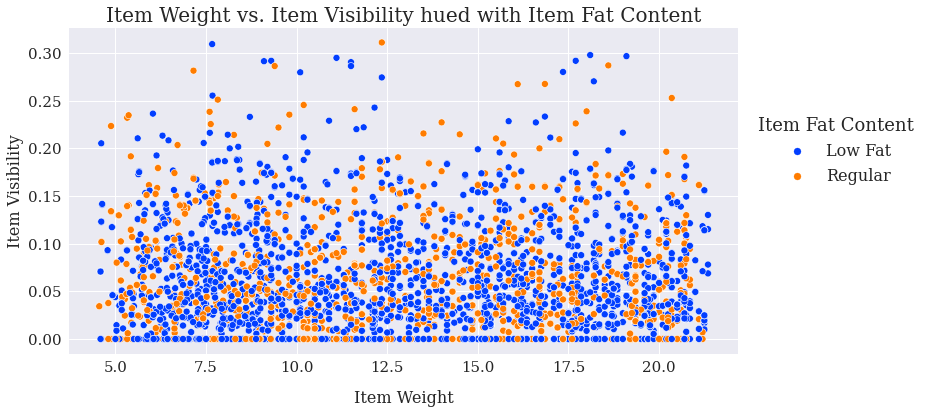

In [21]:
fig,ax = plt.subplots(nrows=1, ncols=1);
fig.set_size_inches(12, 6)
sns.scatterplot(data=df, x="Item_Weight", y="Item_Visibility", hue="Item_Fat_Content", palette='bright')
ax.set_xlabel('Item Weight', fontsize=16, labelpad=15)
ax.set_ylabel('Item Visibility', fontsize=16)
ax.set_title('Item Weight vs. Item Visibility hued with Item Fat Content', fontsize=20);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.legend(loc=(1.02, .5), fontsize=16, title="Item Fat Content")

#For this plot I wanted to take a look the scatter plot between Item weight and Visibility. Then apply a hue
# so we can look at the distrubtuion of how the fat content is spread through out that disturbtion. We can see that
# the item fat content is randomly distubuted throughout the scatter plot and there is no clear correaltion
# between Item Weight and Item Visibility. 
# One interesting thing that has occured in this plot is the straight line going at 12.5 in item weight. this line is 
# side effect of missing data being imputed from earlier in the project. 

### Preprocessing and Imputing Data

In [22]:
X = df.drop(columns=["Item_Outlet_Sales" ])
y = df['Item_Outlet_Sales']

In [23]:
# Train Test SPlit the data

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [24]:
# Creating Selectors
cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")

In [25]:
# Creating our imputers for replace categorical data with the most frequent and numerical with the mean

# We are choosing to replace missing categorical data with the most frequent because we do not want to make another
# data entry most frequent. Keeping it the same. 

# Next we are using mean for numerical data because we want to keep the mean the same on those columns that are missing
# data. 


freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy="mean")

In [26]:
# Creating our scaler and one hot encoder

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

In [27]:
# Creating our numerical pipe 
num_pipe = make_pipeline(mean_imputer, scaler)


# Create the categorical pipe
cat_pipe = make_pipeline(freq_imputer, ohe)

In [28]:
# Create our tuples for the column transformer

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [29]:
# creating preprocessor 
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f89484711e0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f89484a6c50>)])

In [30]:
# fit on our training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f89484711e0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f89484a6c50>)])

In [31]:
# Transforming the data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [32]:
# Check for missing values
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')

0 missing values in training data
0 missing values in testing data


## Linear Regression Model

In [33]:
# Here we are creating a linear regression model and creating a pipeline that goes through prepocessing
# and then applies the model to the data once its been preprocessed
reg = LinearRegression()
reg_pipe = make_pipeline(preprocessor, reg)


# Finally we are fitting the training data to the model in order to make predecitions from the testing data
reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f89484711e0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f89484a6c50>)])),
                ('linearregression', LinearRegression())])

In [34]:
# Getting the test predicitons using the model
test_preds = reg_pipe.predict(X_test)

In [35]:
def eval_regression(true, pred):
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'RMSE: {rmse},\nR^2: {r2} ')

In [36]:
# Evaluation report for Linear Regression on test data
eval_regression(y_test, test_preds)

RMSE: 3069606887029.5894,
R^2: -3.4152098614737853e+18 


In [37]:
train_preds = reg_pipe.predict(X_train)
eval_regression(y_train, train_preds)

RMSE: 985.7250753008361,
R^2: 0.6716781661605304 




### Linear Regression Analysis

The model is returning an r2 score that is neagative which means there is a severe issue with the model itself working with the data at hand. When we look at the item outlet sales we can see that the sales are not in a linear position which might be in the reason behind r2 score being negative and this model working for this dataset. 

### Linear Regression with feature removal.
For this next linear regression we will remove different features to see if it will help improve the results

In [38]:
# make a copy of the data frame
df_removal = df.copy()

X_removal = df_removal.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])
y_removal = df_removal['Item_Outlet_Sales']


# Now train test split the data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_removal,y_removal, random_state=42)

# Here we are creating a linear regression model and creating a pipeline that goes through prepocessing
# and then applies the model to the data once its been preprocessed
reg = LinearRegression()
reg_pipe = make_pipeline(preprocessor, reg)


# Finally we are fitting the training data to the model in order to make predecitions from the testing data
reg_pipe.fit(X_train_r,y_train_r)

# Getting the test predicitons using the model
test_preds_r = reg_pipe.predict(X_test_r)
train_preds_r = reg_pipe.predict(X_train_r)


print("Testing Data")
eval_regression(y_test_r, test_preds_r)
print('\n')
print("Training Data")
eval_regression(y_train_r, train_preds_r)

Testing Data
RMSE: 1092.8513283666869,
R^2: 0.5671134984723627 


Training Data
RMSE: 1139.1054181419815,
R^2: 0.5615541223827856 


When item identifier is removed we actually get an r2 score of .567. My only guess to the reason behind this is because of the complexity that one hot encoding the item identifier added to the data. Looking at the training r2 we can see that there is a high bias which means the model is not fitting the data that well. 

### Random Forest Model

In [40]:
# First we will create a preprocessing column transformer for the Random Forest
# Creating our imputers for replace categorical data with the most frequent and numerical with the mean
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy="mean")


# Creating Selectors
cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")


ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)


cat_pipe = make_pipeline(freq_imputer, ohe)
# Create our tuples for the column transformer

num_tuple = (mean_imputer, num_selector)
cat_tuple = (cat_pipe, cat_selector)

# creating preprocessor 
preprocessor_rf = make_column_transformer(num_tuple, cat_tuple)
preprocessor_rf

ColumnTransformer(transformers=[('simpleimputer', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f542858a0>),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f54285210>)])

In [41]:
# Create the Random Forest Model

rf = RandomForestRegressor()

rf_pipe = make_pipeline(preprocessor_rf, rf)

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f542858a0>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f54285210>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [43]:
# Getting test predictions for Random Forest
rf_test_preds = rf_pipe.predict(X_test)

eval_regression(y_test, rf_test_preds)

RMSE: 1115.7019809955113,
R^2: 0.5488216173802221 


In [42]:
# Finding the max depth
est_depths = [estimator.get_depth() for estimator in rf_pipe[1].estimators_]
max(est_depths)

86

In [41]:
# We will now go through and and find the best depth for the model

depths = range(1,90)
scores_rf = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:
    rf = RandomForestRegressor(max_depth=depth)

    rf_pipe = make_pipeline(preprocessor_rf, rf)

    rf_pipe.fit(X_train, y_train)
    test_preds = rf_pipe.predict(X_test)
    
    scores_rf.loc[depth, 'Test Score'] = r2_score(y_test, test_preds)
scores_rf.head()

,Test Score
1,0.242237
2,0.467213
3,0.5443
4,0.598152
5,0.60461


#### We will now plot the scores to see the best depth

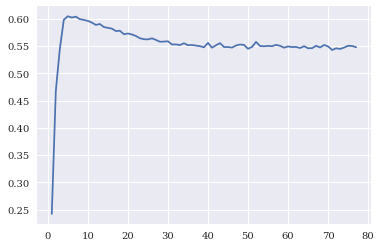

In [42]:
plt.plot(scores_rf['Test Score'])

In [43]:
sorted_scores_rf = scores_rf.sort_values(by='Test Score', ascending=False)
sorted_scores_rf.head()

,Test Score
5,0.60461
7,0.603845
6,0.602224
8,0.599364
4,0.598152


#### Using 5 as the max depth we will now explore the number of trees we should have in the random forest to best improve the R2 score. 

In [45]:
# Now we look for the max number of estimators that will make the model best preform
ests = [10,20,30,40,50,100,150,200,250,300,350]
scores_rf_5  = pd.DataFrame(index=ests, columns=['Test Score'])

for n in ests:
    rf = RandomForestRegressor(max_depth=5, n_estimators=n)
    rf_pipe = make_pipeline(preprocessor_rf, rf)

    rf_pipe.fit(X_train, y_train)
    test_preds = rf_pipe.predict(X_test)
    
    scores_rf_5.loc[n, 'Test Score'] = r2_score(y_test, test_preds)
    

scores_rf_5.head()

,Test Score
10,0.601996
20,0.605714
30,0.603604
40,0.603991
50,0.604723


#### Plotting of the number of estimators that best improves r2 score

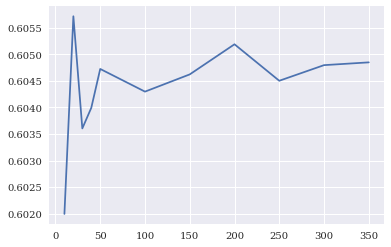

In [47]:
plt.plot(scores_rf_5['Test Score'])

In [49]:
sorted_rf_5 = scores_rf_5.sort_values(by='Test Score', ascending=False)
sorted_rf_5.head()

,Test Score
20,0.605714
200,0.605187
350,0.604846
300,0.604794
50,0.604723


### Finally We see that 20 Estimators and a depth of 5 is going to give best model results

In [44]:
# Final Model
rf_final  = RandomForestRegressor(max_depth=5, n_estimators=20)

rf_pipe_final = make_pipeline(preprocessor_rf, rf_final)

rf_pipe_final.fit(X_train, y_train)

final_test_preds = rf_pipe_final.predict(X_test)
final_train_preds = rf_pipe_final.predict(X_train)


print("Testing Eval")
eval_regression(y_test, final_test_preds)
print('\n')
print('Training Eval')
eval_regression(y_train, final_train_preds)

Testing Eval
RMSE: 1047.4245787369305,
R^2: 0.6023532875783792 


Training Eval
RMSE: 1072.3834198302966,
R^2: 0.611412937396576 


### Random Forest by removing Item Identifier

In [46]:
# make a copy of the data frame
df_removal = df.copy()

X_removal = df_removal.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])
y_removal = df_removal['Item_Outlet_Sales']


# Now train test split the data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_removal,y_removal, random_state=42)


rf_final_r  = RandomForestRegressor(max_depth=5, n_estimators=20)

rf_pipe_final_r = make_pipeline(preprocessor_rf, rf_final_r)

rf_pipe_final_r.fit(X_train_r, y_train_r)

final_test_preds = rf_pipe_final_r.predict(X_test_r)
final_train_preds = rf_pipe_final_r.predict(X_train_r)

print("Testing Eval")
eval_regression(y_test_r, final_test_preds)
print('\n')
print('Training Eval')
eval_regression(y_train_r, final_train_preds)

Testing Eval
RMSE: 1045.435106898038,
R^2: 0.6038624284566769 


Training Eval
RMSE: 1074.6585466019335,
R^2: 0.6097623660938238 


Once again the R2 score is around 61% for both testing and training so there is a high bias in the model and it is not fitting the data that well

### Random Forest Analysis

I would expect that removing Item Identifier would improve the results for the random forest but it does not. The R2 score remains around .6 for the model. Which tells me that we need to go back and look at the data and maybe better split it up One thought that crosses my mind when looking at the data is maybe is that Outlet Type and Outlet Tier are ordinal and have a ranking, But this require talking to sommeone that is more familiar with the dataset and getting their insight. Future iterations of this may include testing more with Random Forest model using ordinal encoding on those features to see if we receive better results. 